<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4 : West Nile Virus Prediction
### Notebook 1 of 4: Data Cleaning and EDA

## Contents:
- [Background](#Background)
- [Import Libraries](#Import-Libraries)
- [Define functions](#Define-functions)
- [Data Import](#Data-Import)
- [Data Cleaning](#Data-Cleaning)
- [EDA](#EDA)
- [Pickle](#Pickle)


## Background
*Back to [Contents](#Contents:)*

The mosquito-borne zoonotic illness West Nile virus (WNV) was first discovered in the United States in New York City in the summer of 1999. WNV swiftly adapted to local populations of Culex vector mosquitoes and bird populations after its first successful invasion in New York, and it soon expanded across the United States.

WNV is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.

In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today. The goal is to catch mosquitos and test for the presence of WNV in the aftermath of the city's recent WNV outbreak. 

Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.

The purpose of this study is to use surveillance data to forecast WNV outbreaks based on date, location, mosquito type, and weather characteristics. The findings of this study will be utilized to improve resource allocation and effectively prevent the spread of this potentially deadly infection. Success is defined as the final model's capacity to offer a sufficiently high level of classification accuracy based on the following two measures:

- **Sensitivity**: Refers to the true positive rate and summarizes how well the positive class (WnvPresent) is predicted, particularly useful metric for imabalance classification dataset.
<br>

- **AUC ROC score**: The Area Under the Curve (AUC) - ROC curve is a performance statistic for classification issues at various threshold levels. AUC represents the degree or measure of separability, whereas ROC is a probability curve. It indicates how well the model can distinguish between classes. The AUC indicates how well the model predicts 0 classes as 0 and 1 courses as 1. The higher the AUC, the better the model predicts 0 classes as 0 and 1 classes as 1.

## Import Libraries
*Back to [Contents](#Contents:)*

In [1]:
# Imports:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler 

from sklearn.cluster import KMeans

import lightgbm as lgb

import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

get_ipython().run_line_magic('matplotlib', 'inline')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import geopandas as gpd

import datetime

In [2]:
#steps to install geopandas

#!pip install pipwin
#!pipwin install gdal
#!pipwin install fiona
#!pip install geopandas
#!pipwin install rasterio
#!pip install contextily

In [3]:
#!pip install imblearn

In [4]:
#!pip install lightgbm

## Define functions
*Back to [Contents](#Contents:)*

In [5]:
# the fuction will 
# 1. plot neighborhoods map of chicago
# 2. plot 2 weather stations on the map
# 3. based on the input parameters,
#   a. convert the input dataframe into geopandas dataframe
#   b. plot the dataframe on the chicago map. 
#   c. if the dataframe contain column 'NumMosquitos', the function will adjust the markersize according to 'NumMosquitos'

def plot_geodata(dict_df   # dictionary containing dataframe and its name  
                ):
    colors = ['black','orange','pink','yellow']
    markersizes = [3, 1, 14, 5]
    zorders = [3, 1, 4, 2]
    
    fig_, ax_ = plt.subplots(figsize=(20,20))
    
    # plot neighborhoods map of chicago
    geojson_file = './assets/Boundaries_Community_Areas.geojson'
    neighborhoods = gpd.read_file(geojson_file)
    neighborhoods.plot(ax=ax_)
    
    # plot station
    # initialize list of lists
    list_station = [['1',  41.995,-87.933], ['2', 41.786,-87.752]]
    df_station = pd.DataFrame(list_station, columns=['Station', 'Latitude', 'Longitude'])
    gdf = gpd.GeoDataFrame(df_station, geometry=gpd.points_from_xy(df_station.Longitude, df_station.Latitude))
    gdf.plot(ax=ax_, color='yellow', markersize=20, zorder=5, label="Weather station")
    
    # plot input dataframes
    i=0
    for label_df, df in dict_df.items():
        color_ = colors[i]
        zorder_ = zorders[i]
        label_ = label_df
        
        # if the dataframe has column 'NumMosquitos', the markersize will be adjusted according to this column
        if 'NumMosquitos' in df.columns:
            markersize_ = df['NumMosquitos']*3
        else:
            markersize_ = markersizes[i]
        

        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
        gdf.plot(ax=ax_, color=color_, markersize=markersize_, zorder=zorder_, label=label_)
        i += 1
        
    ax_.legend(loc='lower left', fontsize=12, markerscale=3)
    plt.show()
    return

## Data Import
- [Train data](#Train-data)
- [Test data](#Test-data)
- [Spray data](#Spray-data)
- [Weather data](#Weather-data)

*Back to [Contents](#Contents:)*

### Train data

In [6]:
df_train = pd.read_csv("./assets/train.csv")

In [7]:
df_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.99,-87.77,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,4,0


In [8]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Block,"10,506.00",35.69,24.34,10.00,12.00,33.00,52.00,98.00
Latitude,"10,506.00",41.84,0.11,41.64,41.73,41.85,41.95,42.02
Longitude,"10,506.00",-87.70,0.10,-87.93,-87.76,-87.69,-87.63,-87.53
AddressAccuracy,"10,506.00",7.82,1.45,3.00,8.00,8.00,9.00,9.00
NumMosquitos,"10,506.00",12.85,16.13,1.00,2.00,5.00,17.00,50.00
WnvPresent,"10,506.00",0.05,0.22,0.00,0.00,0.00,0.00,1.00


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


### Test data

In [10]:
df_test = pd.read_csv("./assets/test.csv")
df_test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9


### Spray data

In [11]:
df_spray = pd.read_csv("./assets/spray.csv")
df_spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.39,-88.09
1,2011-08-29,6:57:08 PM,42.39,-88.09
2,2011-08-29,6:57:18 PM,42.39,-88.09
3,2011-08-29,6:57:28 PM,42.39,-88.09
4,2011-08-29,6:57:38 PM,42.39,-88.09


In [12]:
df_spray.describe()

,Latitude,Longitude
count,"14,835.00","14,835.00"
mean,41.90,-87.74
std,0.10,0.07
min,41.71,-88.10
25%,41.79,-87.79
50%,41.94,-87.73
75%,41.98,-87.69
max,42.40,-87.59


In [13]:
df_spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


### Weather data

In [14]:
df_weather = pd.read_csv("./assets/weather.csv")
df_weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.70,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.70,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.00,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.30,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.70,7,11.9


In [15]:
df_weather.describe()

,Station,Tmax,Tmin,DewPoint,ResultSpeed,ResultDir
count,"2,944.00","2,944.00","2,944.00","2,944.00","2,944.00","2,944.00"
mean,1.50,76.17,57.81,53.46,6.96,17.49
std,0.50,11.46,10.38,10.68,3.59,10.06
min,1.00,41.00,29.00,22.00,0.10,1.00
25%,1.00,69.00,50.00,46.00,4.30,7.00
50%,1.50,78.00,59.00,54.00,6.40,19.00
75%,2.00,85.00,66.00,62.00,9.20,25.00
max,2.00,104.00,83.00,75.00,24.10,36.00


In [16]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

## Data Cleaning
We will check and handle the following in the datasets:
- [Train data](#Clean-Train-data)
- [Test data](#Clean-Test-data)
- [Spray data](#Clean-Spray-data)
- [Weather data](#Clean-Weather-data)

*Back to [Contents](#Contents:)*

### Clean Train data

In [17]:
# check null values
df_train.isnull().sum().sort_values(ascending=False)

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [19]:
# change "Date" datatype to datetime
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), ob

### Clean Test data

In [20]:
# check null values
df_test.isnull().sum().sort_values(ascending=False)

Id                        0
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
dtype: int64

In [21]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


In [22]:
# change "Date" datatype to datetime
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  int64         
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 9.8+ MB


### Clean Spray data

In [23]:
# check nulls
df_spray.isnull().sum().sort_values(ascending=False)

Time         584
Date           0
Latitude       0
Longitude      0
dtype: int64

In [24]:
df_spray.shape

(14835, 4)

In [25]:
df_spray.head(10)

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.39,-88.09
1,2011-08-29,6:57:08 PM,42.39,-88.09
2,2011-08-29,6:57:18 PM,42.39,-88.09
3,2011-08-29,6:57:28 PM,42.39,-88.09
4,2011-08-29,6:57:38 PM,42.39,-88.09
5,2011-08-29,6:57:48 PM,42.39,-88.09
6,2011-08-29,6:57:58 PM,42.39,-88.09
7,2011-08-29,6:58:08 PM,42.39,-88.09
8,2011-08-29,6:58:18 PM,42.39,-88.09
9,2011-08-29,6:58:28 PM,42.39,-88.09


It looks like the spray data is taking place every 10 seconds at the same location.

In [26]:
df_spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [27]:
df_spray[df_spray.Time.isnull()].Date.value_counts()

2011-09-07    584
Name: Date, dtype: int64

In [28]:
df_spray[df_spray['Date']=='2011-09-07'].count()

Date         2114
Time         1530
Latitude     2114
Longitude    2114
dtype: int64

In [29]:
df_spray[df_spray['Date']=='2011-09-07']

,Date,Time,Latitude,Longitude
95,2011-09-07,7:52:52 PM,41.98,-87.79
96,2011-09-07,7:53:02 PM,41.98,-87.79
97,2011-09-07,7:53:12 PM,41.98,-87.79
98,2011-09-07,7:53:22 PM,41.98,-87.79
99,2011-09-07,7:53:32 PM,41.98,-87.79
100,2011-09-07,7:53:42 PM,41.98,-87.79
101,2011-09-07,7:53:52 PM,41.98,-87.79
102,2011-09-07,7:54:02 PM,41.98,-87.79
103,2011-09-07,7:54:12 PM,41.98,-87.79
104,2011-09-07,7:54:22 PM,41.98,-87.79


There are 584 null values in "Time" column, all of which happens on 2011-09-07.

In [30]:
df_spray[df_spray.duplicated()].nunique()

Date         1
Time         2
Latitude     2
Longitude    2
dtype: int64

In [31]:
df_spray[df_spray.duplicated()].count()

Date         541
Time         541
Latitude     541
Longitude    541
dtype: int64

In [32]:
df_spray[df_spray.duplicated()]['Date'].unique()

array(['2011-09-07'], dtype=object)

All 541 duplicated values also happen on 2011-09-07, so we can likely conclude that the data collected in 2011 is not that clean. We will drop the nulls and duplicates in the spray data.

In [33]:
# drop duplicates and drop null values 
df_spray = df_spray.drop_duplicates()
df_spray = df_spray.dropna()

In [34]:
# change "Date" datatype to datetime
df_spray['Date']=pd.to_datetime(df_spray['Date'])
df_spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13710 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       13710 non-null  datetime64[ns]
 1   Time       13710 non-null  object        
 2   Latitude   13710 non-null  float64       
 3   Longitude  13710 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 535.5+ KB


### Clean Weather data

In [35]:
df_weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [36]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [37]:
# change "Date" datatype to datetime
df_weather['Date'] = pd.to_datetime(df_weather['Date'])
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [38]:
# Tavg column has some values of 'M'
df_weather['Tavg'].value_counts()

73    138
77    117
70    117
75    110
71    109
74    107
72    104
69    103
78    102
76    100
68     99
79     98
66     93
67     89
61     88
64     86
80     84
65     84
63     81
57     67
62     66
60     61
50     57
81     55
53     49
58     49
54     48
82     48
55     48
56     46
52     46
59     45
51     36
83     34
49     29
45     28
47     24
46     24
84     21
44     19
48     17
85     16
86     16
42     15
43     12
M      11
87      9
41      7
40      5
39      4
89      4
88      4
91      4
37      2
38      2
90      2
36      2
92      1
93      1
94      1
Name: Tavg, dtype: int64

In [39]:
# Looking at all the rows where Tavg=="M", total 11 rows
df_weather.query("Tavg == 'M'")

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
7,2,2007-05-04,78,51,M,M,42,50,M,M,-,-,,M,M,M,0.00,29.36,30.04,10.10,7,10.4
505,2,2008-07-08,86,46,M,M,68,71,M,M,-,-,TS RA,M,M,M,0.28,29.16,29.80,7.40,24,8.3
675,2,2008-10-01,62,46,M,M,41,47,M,M,-,-,,M,M,M,0.00,29.30,29.96,10.90,33,11.0
1637,2,2011-07-22,100,71,M,M,70,74,M,M,-,-,TS TSRA BR,M,M,M,0.14,29.23,29.86,3.80,10,8.2
2067,2,2012-08-22,84,72,M,M,51,61,M,M,-,-,,M,M,M,0.00,29.39,M,4.70,19,M
2211,2,2013-05-02,71,42,M,M,39,45,M,M,-,-,,M,M,M,0.00,29.51,30.17,15.80,2,16.1
2501,2,2013-09-24,91,52,M,M,48,54,M,M,-,-,,M,M,M,0.00,29.33,30.00,5.80,9,7.7
2511,2,2013-09-29,84,53,M,M,48,54,M,M,-,-,RA BR,M,M,M,0.22,29.36,30.01,6.30,36,7.8
2525,2,2013-10-06,76,48,M,M,44,50,M,M,-,-,RA DZ BR,M,M,M,0.06,29.10,29.76,10.10,25,10.6
2579,2,2014-05-02,80,47,M,M,43,47,M,M,-,-,RA,M,M,M,0.04,29.10,29.79,10.70,23,11.9


In [40]:
# fill these rows with average value of Tmax and Tmin
df_weather['Tavg'] = np.where(df_weather['Tavg']=='M',
                              (df_weather['Tmax']+df_weather['Tmin'])/2,
                              df_weather['Tavg'])

# change datatype of Tavg into "float"
df_weather['Tavg'] = df_weather['Tavg'].astype(float)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   float64       
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

**Special symbols**

Symbols that appear on many of the individual summaries: (*) less than one half; (T) trace, an amount too small to measure; (—) below zero temperatures are preceded by a minus sign; (M) missing data.

Precipitation refers to the inches of water equivalent in the total of all forms of liquid or frozen precipitation that fell during each month. Snowfall refers to the actual amount of snow in inches that fell during the month. T (trace) is a precipitation amount of less than 0.005 in (note: in estimating the water equivalent of snow, a ratio of 10 in snow equal 1 in water is customarily employed).

PrecipTotal is likely the sum of the columns Water1 and SnowFall.

**Reference:**
https://www.encyclopedia.com/environment/encyclopedias-almanacs-transcripts-and-maps/local-climatological-data-reports


In [41]:
df_weather['Water1'].value_counts()

M    2944
Name: Water1, dtype: int64

In [42]:
df_weather['SnowFall'].value_counts()

M      1472
0.0    1459
  T      12
0.1       1
Name: SnowFall, dtype: int64

In [43]:
# There are 318 instances of "T" and 2 instances of "M" in column "PrecipTotal"
df_weather['PrecipTotal'].value_counts()

0.00    1577
  T      318
0.01     127
0.02      63
0.03      46
0.04      36
0.05      32
0.08      28
0.12      28
0.06      27
0.07      23
0.16      21
0.09      21
0.11      20
0.14      20
0.17      17
0.28      15
0.13      14
0.19      14
0.18      14
0.20      13
0.15      13
0.23      11
0.25      11
0.26      11
0.10      10
0.24      10
0.31       9
0.39       9
0.40       9
0.21       9
0.29       9
0.43       9
0.34       8
0.32       8
0.22       8
0.33       7
0.41       7
0.50       7
0.48       7
0.37       7
0.45       7
0.59       7
0.30       7
0.80       6
0.63       6
0.84       6
0.65       6
0.27       6
0.92       5
0.68       5
0.44       5
0.36       5
0.54       5
0.93       5
0.85       5
1.23       4
0.72       4
0.75       4
0.64       4
0.52       4
0.70       4
0.55       4
0.97       4
0.51       4
0.58       4
0.89       4
0.66       4
0.87       3
0.60       3
1.31       3
1.05       3
1.01       3
0.77       3
1.03       3
0.56       3
0.88       3

In [44]:
# change values of "T" to 0.005
df_weather['PrecipTotal'] = np.where(df_weather['PrecipTotal'].str.strip()=='T',\
                                     0.005, df_weather['PrecipTotal'])

# change values of "M to 0
df_weather['PrecipTotal']=np.where(df_weather['PrecipTotal'].str.strip()=='M',\
                                   0, df_weather['PrecipTotal'])

# change datatype to "float"
df_weather['PrecipTotal'] = df_weather['PrecipTotal'].astype(float)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   float64       
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [45]:
df_weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67.00,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.70,27,9.2
1,2,2007-05-01,84,52,68.00,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.70,25,9.6
2,1,2007-05-02,59,42,51.00,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.00,4,13.4
3,2,2007-05-02,60,43,52.00,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.30,2,13.4
4,1,2007-05-03,66,46,56.00,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.70,7,11.9


**Sunrise and sunset info is not available for Station 2 in df_weather. 
<br> Therefore, we will split df_weather based on the weather station (either 1 or 2) and then copy values over based on the Date value.**

In [46]:
# filter df_weather into all Station 1 data
df_weather_1 = df_weather.query("Station == 1")
df_weather_1.set_index("Date", inplace=True)
df_weather_1.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67.00,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.70,27,9.2
2007-05-02,1,59,42,51.00,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.00,4,13.4
2007-05-03,1,66,46,56.00,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.70,7,11.9
2007-05-04,1,66,49,58.00,4,41,50,7,0,0444,1852,RA,0,M,0.0,0.01,29.31,30.05,10.40,8,10.8
2007-05-05,1,66,53,60.00,5,38,49,5,0,0443,1853,,0,M,0.0,0.01,29.40,30.10,11.70,7,12.0


In [47]:
# change datatype of Sunrise and Sunset to "int"
df_weather_1['Sunrise'] = df_weather_1['Sunrise'].astype(int)
df_weather_1['Sunset'] = df_weather_1['Sunset'].astype(int)

# create new feature "Day_length" from difference between sunrise and sunset
# basically convert Sunset and Sunrise into "minutes" and then change back to "hours"
df_weather_1['Day_length'] =((df_weather_1['Sunset']//100*60 + df_weather_1['Sunset']%100) -
                             (df_weather_1['Sunrise']//100*60+df_weather_1['Sunrise']%100))/60

df_weather_1[['Sunrise','Sunset','Day_length']].head(5)

,Sunrise,Sunset,Day_length
Date,,,
2007-05-01,448,1849,14.02
2007-05-02,447,1850,14.05
2007-05-03,446,1851,14.08
2007-05-04,444,1852,14.13
2007-05-05,443,1853,14.17


**We filter the Weather dataset for all Station 2 data next.**

In [48]:
# filter df_weather into all Station 2 data
df_weather_2 = df_weather.query("Station == 2")
df_weather_2.set_index("Date", inplace=True)

In [49]:
# copy the 'Sunrise', 'Sunset' and 'Day_length' from df_weather_1 to df_weather_2
df_weather_2.loc[:,'Sunrise'] = np.where(True, df_weather_1['Sunrise'], 0)
df_weather_2.loc[:,'Sunset'] = np.where(True,df_weather_1['Sunset'], 0)
df_weather_2.loc[:,'Day_length'] = np.where(True,df_weather_1['Day_length'],0)
df_weather_2.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Day_length
Date,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,2,84,52,68.00,M,51,57,0,3,448,1849,,M,M,M,0.00,29.18,29.82,2.70,25,9.6,14.02
2007-05-02,2,60,43,52.00,M,42,47,13,0,447,1850,BR HZ,M,M,M,0.00,29.44,30.08,13.30,2,13.4,14.05
2007-05-03,2,67,48,58.00,M,40,50,7,0,446,1851,HZ,M,M,M,0.00,29.46,30.12,12.90,6,13.2,14.08
2007-05-04,2,78,51,64.50,M,42,50,M,M,444,1852,,M,M,M,0.00,29.36,30.04,10.10,7,10.4,14.13
2007-05-05,2,66,54,60.00,M,39,50,5,0,443,1853,,M,M,M,0.01,29.46,30.09,11.20,7,11.5,14.17


In [50]:
# join back df_weather_1 and df_weather_2
df_weather = pd.concat([df_weather_1, df_weather_2])
df_weather.shape

(2944, 22)

## EDA
- [EDA on Train data](#EDA-Train-data)
- [EDA on Test data](#EDA-Test-data)
- [EDA on Spray data](#EDA-Spray-data)
- [EDA on Weather data](#EDA-Weather-data)

*Back to [Contents](#Contents:)*

### EDA Train data

In [51]:
# Checking the % of WnV entries
df_train['WnvPresent'].value_counts(normalize=True)

0   0.95
1   0.05
Name: WnvPresent, dtype: float64

Dataset is skewed, only about 5% of entries are labelled as having WnV present.

**Plotting location of weather stations and mosquito traps from train set**

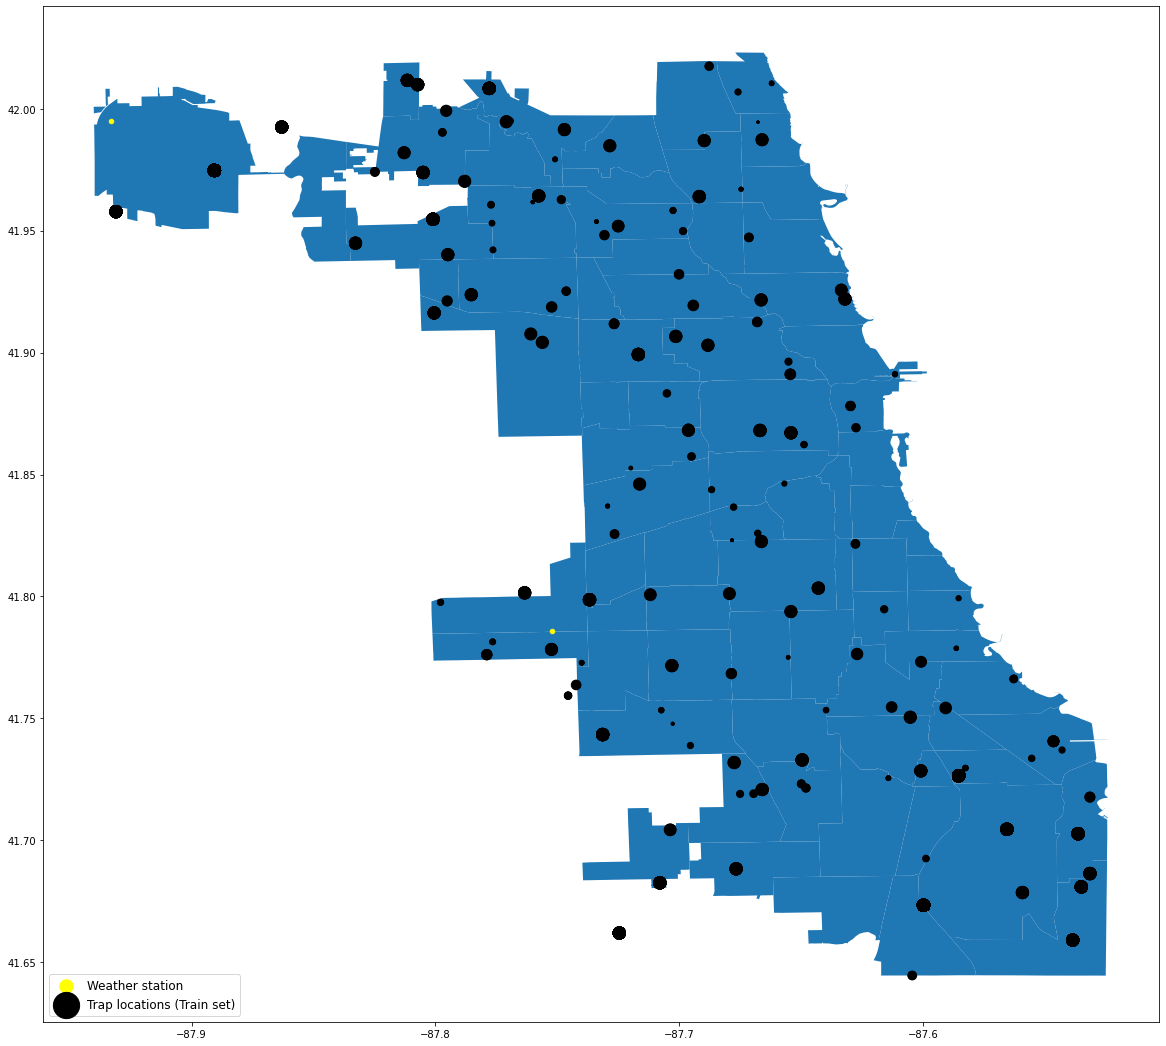

In [52]:
# plot weather station and trap locations to the map
# trap locations are adjusted by total number of mosquitoes
dict_df = {'Trap locations (Train set)':df_train}           
plot_geodata(dict_df)

**Mosquito Species Analysis**

In [53]:
species_list = df_train['Species'].unique().tolist()
print(species_list)

['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS', 'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS', 'CULEX ERRATICUS']


In [54]:
df_train['Species'].value_counts(normalize=True)

CULEX PIPIENS/RESTUANS   0.45
CULEX RESTUANS           0.26
CULEX PIPIENS            0.26
CULEX TERRITANS          0.02
CULEX SALINARIUS         0.01
CULEX TARSALIS           0.00
CULEX ERRATICUS          0.00
Name: Species, dtype: float64

In [55]:
# finding the frequency of WnV given mosquito species
species_wnv_pct = []
for specie in species_list:
    wnv_pct = df_train[df_train["Species"] == specie]['WnvPresent'].mean()
    species_wnv_pct.append(wnv_pct)

# print out results
for specie, pct in zip(species_list, species_wnv_pct):
    print(f"{specie}: {round(pct,4)}")

CULEX PIPIENS/RESTUANS: 0.0551
CULEX RESTUANS: 0.0179
CULEX PIPIENS: 0.0889
CULEX SALINARIUS: 0.0
CULEX TERRITANS: 0.0
CULEX TARSALIS: 0.0
CULEX ERRATICUS: 0.0


In [56]:
# Also create a mosquito count dataframe
mosquito_count = pd.DataFrame(df_train['Species'].value_counts().reset_index())
mosquito_count = mosquito_count.rename(columns={'index': 'Species', 
                                                'Species': 'MosquitoCount'})
mosquito_count

,Species,MosquitoCount
0,CULEX PIPIENS/RESTUANS,4752
1,CULEX RESTUANS,2740
2,CULEX PIPIENS,2699
3,CULEX TERRITANS,222
4,CULEX SALINARIUS,86
5,CULEX TARSALIS,6
6,CULEX ERRATICUS,1


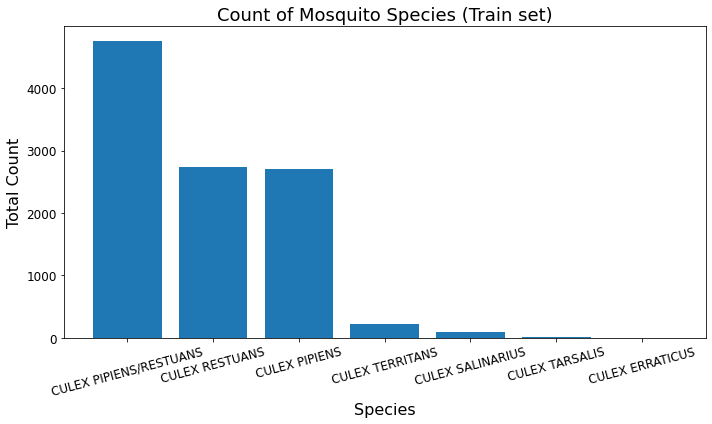

In [57]:
# plot a bar chart to visualize results
plt.figure(figsize=(10,6))
plt.bar(x='Species', height='MosquitoCount', data=mosquito_count)
plt.title('Count of Mosquito Species (Train set)', size=18)
plt.xlabel('Species', size=16)
plt.ylabel('Total Count', size=16)
plt.xticks(size=12, rotation=15)
plt.yticks(size=12)
plt.tight_layout()

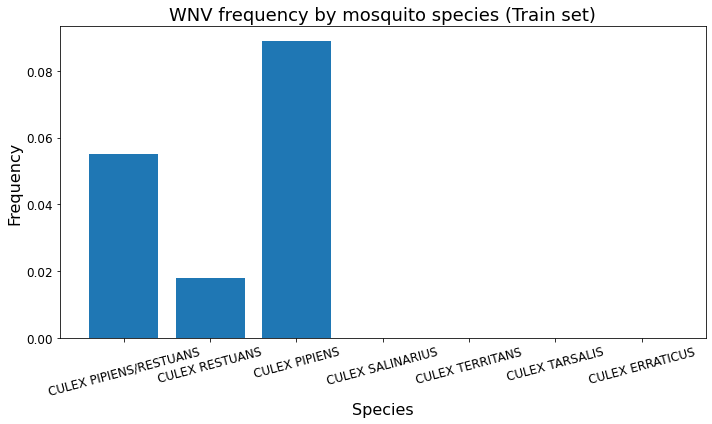

In [58]:
# plot a bar chart to visualize results
plt.figure(figsize=(10,6))
plt.bar(x=species_list, height=species_wnv_pct)
plt.title('WNV frequency by mosquito species (Train set)', size=18)
plt.xlabel('Species', size=16)
plt.ylabel('Frequency', size=16)
plt.xticks(size=12, rotation=15)
plt.yticks(size=12)
plt.tight_layout()

3 species of mosquitoes are likely to cause the West Nile Virus, the Culex Pipiens/Restuans, Culex Pipiens and Culex Restuans. These 3 species alone account for 97% of the Train data. The other species do not cause the virus and will be grouped together as "Others" later.

**Address Accuracy**

In [59]:
# about 82% of address is accurate
df_train.AddressAccuracy.value_counts(normalize=True)

8   0.44
9   0.38
5   0.17
3   0.01
Name: AddressAccuracy, dtype: float64

In [60]:
# list of address accuracy
aa_list = sorted(df_train['AddressAccuracy'].unique().tolist())

# finding the frequency of WnV given address accuracy
aa_wnv_pct = []
for aa in aa_list:
    wnv_pct = df_train[df_train["AddressAccuracy"] == aa]['WnvPresent'].mean()
    aa_wnv_pct.append(wnv_pct)

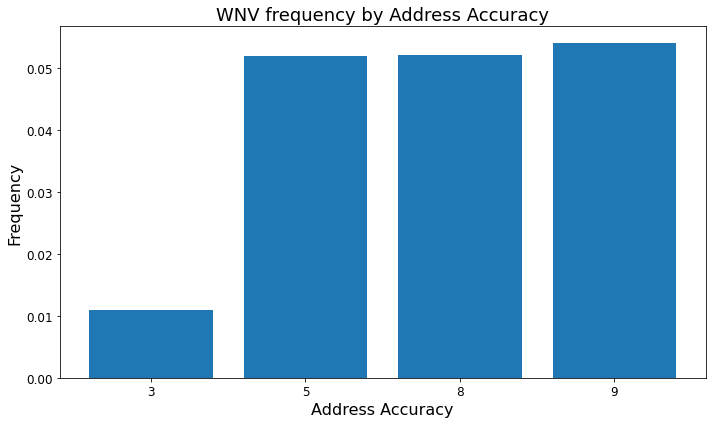

In [61]:
plt.figure(figsize=(10, 6))
plt.bar(x=[str(i) for i in (aa_list)], height=aa_wnv_pct)
plt.title('WNV frequency by Address Accuracy', size=18)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Address Accuracy', size=16)
plt.ylabel('Frequency', size=16)
plt.tight_layout()

This seems to suggest that the a higher Address Accuracy predicts the presence of the WnV, but no other conclusion can be made.

**Number of Traps**

In [62]:
df_train['Trap'].count()

10506

In [63]:
df_train['Trap'].nunique()

136

In [64]:
df_train['Trap'].value_counts(ascending=False).head()

T900    750
T115    542
T138    314
T002    185
T135    183
Name: Trap, dtype: int64

In [65]:
df_train.query("Trap=='T900'").iloc[0,:]

Date                                                    2009-05-28 00:00:00
Address                   ORD Terminal 5, O'Hare International Airport, ...
Species                                                      CULEX RESTUANS
Block                                                                    10
Street                                                      W OHARE AIRPORT
Trap                                                                   T900
AddressNumberAndStreet                   1000  W OHARE AIRPORT, Chicago, IL
Latitude                                                              41.97
Longitude                                                            -87.89
AddressAccuracy                                                           9
NumMosquitos                                                             30
WnvPresent                                                                0
geometry                                       POINT (-87.890615 41.974689)
Name: 3868, 

There are 136 unique traps, of which T900 at Ohare Airport was sampled the most at 750 times.

**Number of Mosquitoes vs Presence of WnV**

In [66]:
df_wnvpresent = df_train.query("WnvPresent==1")
df_not_wnvpresent = df_train.query("WnvPresent==0")

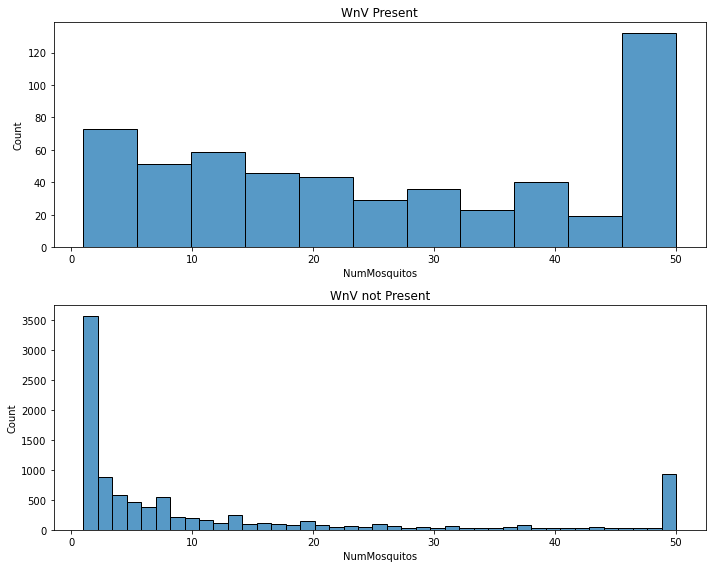

In [67]:
fig,ax = plt.subplots(2,figsize=(10,8))
sns.histplot(data=df_wnvpresent, x='NumMosquitos', ax=ax[0]).set(title='WnV Present')
sns.histplot(data=df_not_wnvpresent, x='NumMosquitos', ax=ax[1]).set(title='WnV not Present')
plt.tight_layout();

The way to interpret this is that there is a higher mosquito count when WnV is present, but again this is not conclusive. Chart above on the Count of Mosquito Species vs WNV frequency tells a better story that majority of WNV cases are caused by 3 species which also accounts for majority of the mosquito counts. 

**Checking for the effect of seasonality**

In [68]:
# Breaking down the Date column into years, months, weeks and day
# Allows us to evaluate whether there is any seasonality in the train dataset
df_train['year'] = df_train['Date'].dt.year
df_train['month'] = df_train['Date'].dt.month
df_train['week'] = df_train['Date'].dt.isocalendar().week
df_train['day'] = df_train['Date'].dt.day
df_train['year_month'] = df_train['Date'].dt.strftime("%Y-%m")
df_train.head().T

,0,1,2,3,4
Date,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00
Address,"4100 North Oak Park Avenue, Chicago, IL 60634,...","4100 North Oak Park Avenue, Chicago, IL 60634,...","6200 North Mandell Avenue, Chicago, IL 60646, USA","7900 West Foster Avenue, Chicago, IL 60656, USA","7900 West Foster Avenue, Chicago, IL 60656, USA"
Species,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX RESTUANS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS
Block,41,41,62,79,79
Street,N OAK PARK AVE,N OAK PARK AVE,N MANDELL AVE,W FOSTER AVE,W FOSTER AVE
Trap,T002,T002,T007,T015,T015
AddressNumberAndStreet,"4100 N OAK PARK AVE, Chicago, IL","4100 N OAK PARK AVE, Chicago, IL","6200 N MANDELL AVE, Chicago, IL","7900 W FOSTER AVE, Chicago, IL","7900 W FOSTER AVE, Chicago, IL"
Latitude,41.95,41.95,41.99,41.97,41.97
Longitude,-87.80,-87.80,-87.77,-87.82,-87.82
AddressAccuracy,9,9,9,8,8


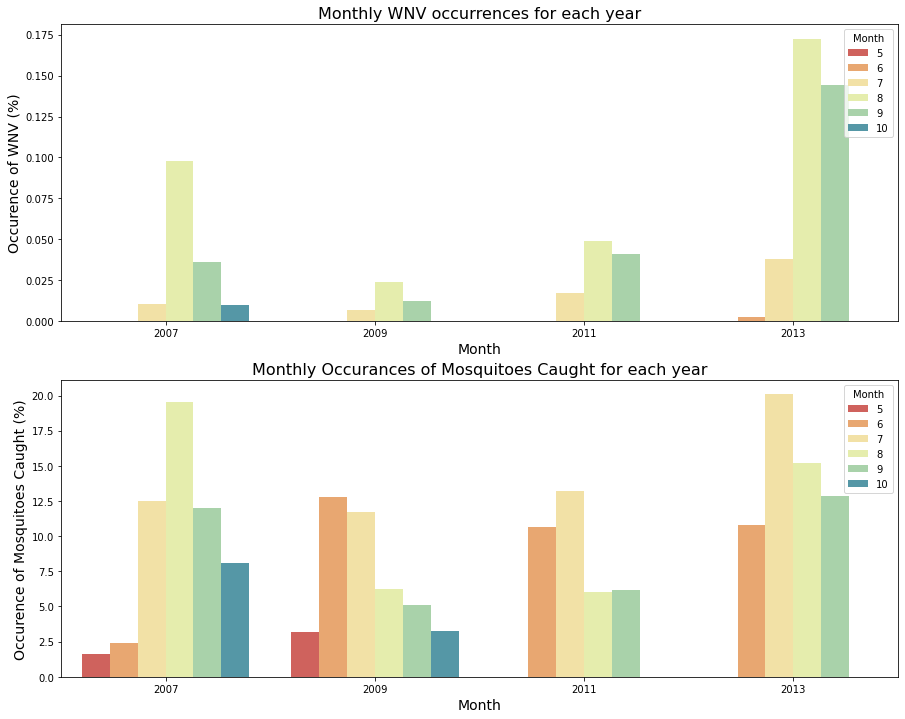

In [69]:
# Visualise occurences of WNV
# Create 2 subplots
fig, ax = plt.subplots(nrows = 2, figsize=(15,12))

# The monthly WNV occurrences each year plotted as a barplot
wnv = df_train[['Date', 'WnvPresent', 'year', 'month', 'week', 'NumMosquitos']]
sns.barplot( data=wnv, x='year', y='WnvPresent',
            hue='month', ci=None, palette='Spectral', ax=ax[0])
ax[0].legend(fontsize = 14)
ax[0].set_title('Monthly WNV occurrences for each year', fontsize=16)
ax[0].set_xlabel('Month',fontsize=14)
ax[0].set_ylabel('Occurence of WNV (%)',fontsize=14)
ax[0].legend(title='Month', loc="upper right")

# The monthly occurrence of mosquitoes caught each year plotted as a barplot
sns.barplot(data=wnv, x='year', y='NumMosquitos', 
            hue='month', ci=None, palette='Spectral', ax=ax[1])
ax[1].legend(fontsize = 14)
ax[1].set_title('Monthly Occurances of Mosquitoes Caught for each year', fontsize=16)
ax[1].set_ylabel("Occurence of Mosquitoes Caught (%)",fontsize=14)
ax[1].set_xlabel("Month",fontsize=14)
plt.legend(title='Month', loc="upper right")
plt.show()

**There seems to be a seasonality trend, with WNV occurence peaking in August, and the number of mosquitos caught peaking in July/August. July and August are summer and typically the season when heat and humidity provide the right condition for mosquitoes to breed.**

### EDA Test data

In [115]:
# Also create a mosquito count dataframe for the Test set
mosquito_count_test = pd.DataFrame(df_test['Species'].value_counts().reset_index())
mosquito_count_test = mosquito_count_test.rename(columns={'index': 'Species', 
                                                'Species': 'MosquitoCount'})
mosquito_count_test

,Species,MosquitoCount
0,CULEX PIPIENS/RESTUANS,15359
1,CULEX RESTUANS,14670
2,CULEX PIPIENS,14521
3,CULEX SALINARIUS,14355
4,CULEX TERRITANS,14351
5,CULEX TARSALIS,14347
6,UNSPECIFIED CULEX,14345
7,CULEX ERRATICUS,14345


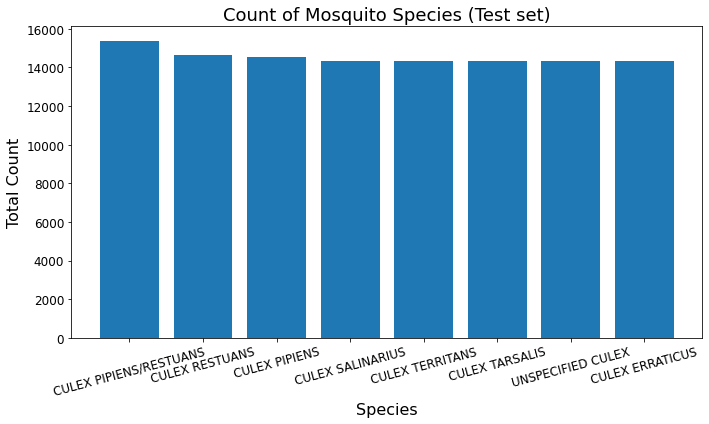

In [117]:
# plot a bar chart to visualize results
plt.figure(figsize=(10,6))
plt.bar(x='Species', height='MosquitoCount', data=mosquito_count_test)
plt.title('Count of Mosquito Species (Test set)', size=18)
plt.xlabel('Species', size=16)
plt.ylabel('Total Count', size=16)
plt.xticks(size=12, rotation=15)
plt.yticks(size=12)
plt.tight_layout()

This looks like a very even dataset, with each species uniformly spread out. However, as seen in the EDA of the Train set, the majority of the mosquitoes that spread the virus belongs only to the first 3 Species.

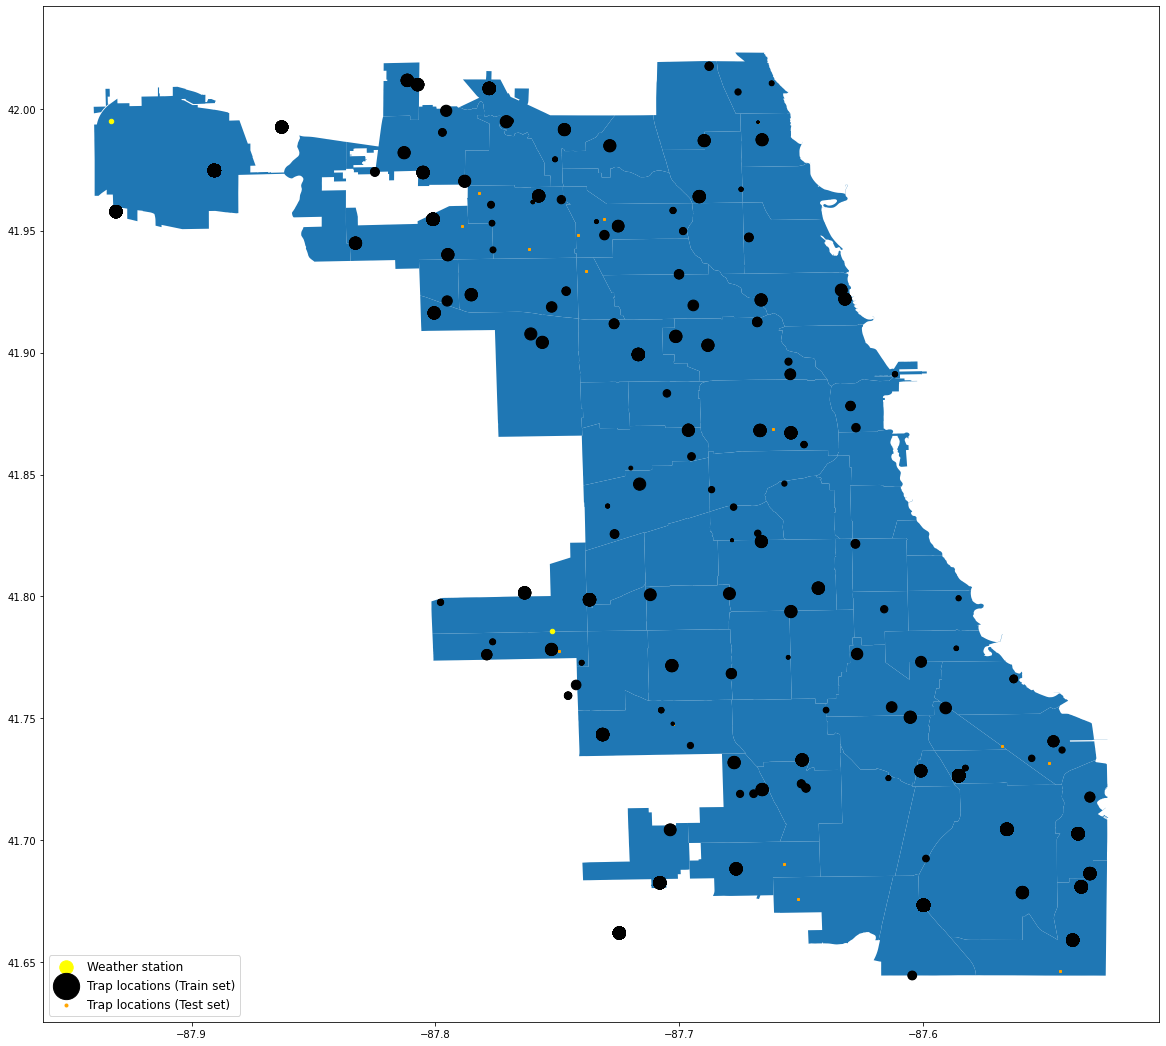

In [70]:
# plot location of trap locations of test data relative to train data
dict_df = {'Trap locations (Train set)':df_train, 
           'Trap locations (Test set)':df_test,
          }
plot_geodata(dict_df)

### EDA Spray data

In [71]:
# find the location (latitude and longitude) of all the hotspots
df_wnvpresent = df_train.query('WnvPresent==1')[['Date', 'Latitude', 'Longitude']]
#df_station = pd.DataFrame(list_station, columns=['Latitude', 'Longitude'])
df_wnvpresent.head()

,Date,Latitude,Longitude
553,2007-07-18,41.69,-87.53
603,2007-07-25,41.67,-87.60
611,2007-07-25,41.67,-87.60
618,2007-07-25,41.67,-87.60
660,2007-07-25,41.67,-87.60


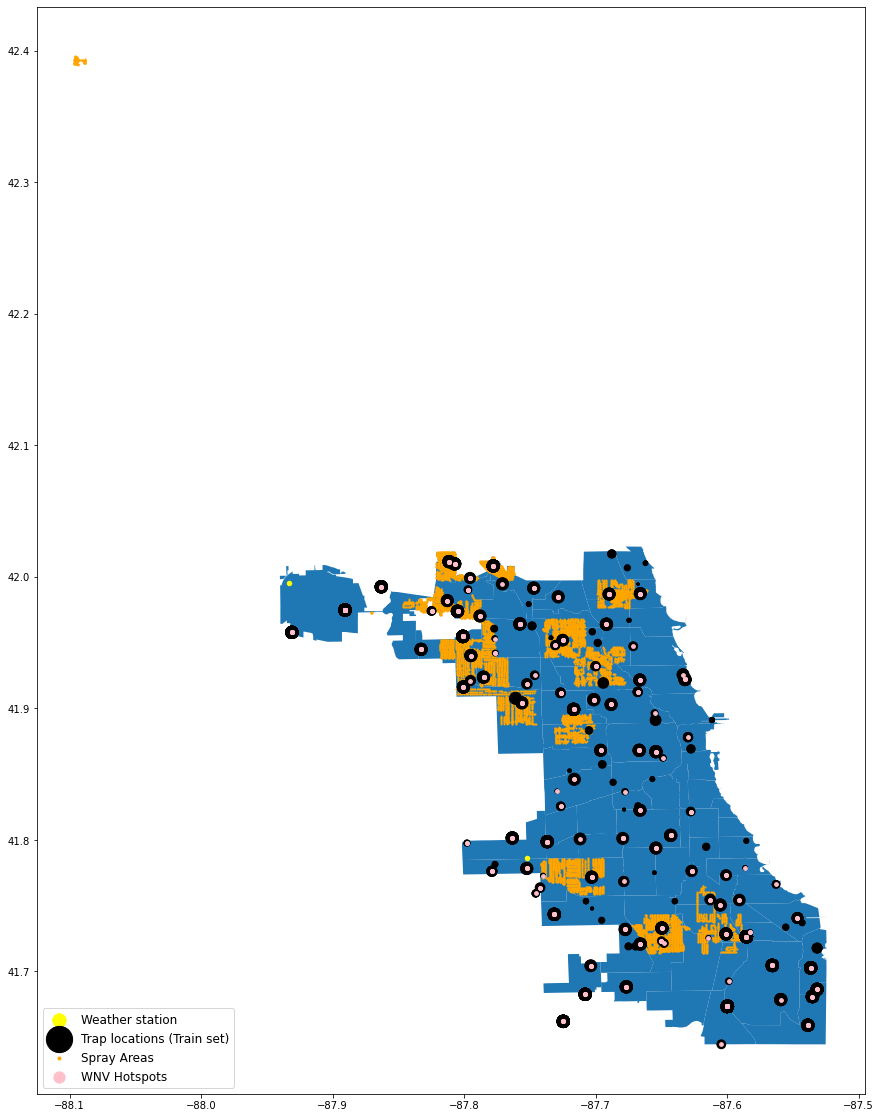

In [72]:
dict_df = {'Trap locations (Train set)':df_train, 
           'Spray Areas':df_spray,
           'WNV Hotspots':df_wnvpresent
          }
plot_geodata(dict_df)

**One spray zone shown to be in another state, which we will ignore and only consider spray data close to the traps, whose latitude are all below 42.3.**

In [73]:
df_spray = df_spray.query("Latitude < 42.3")

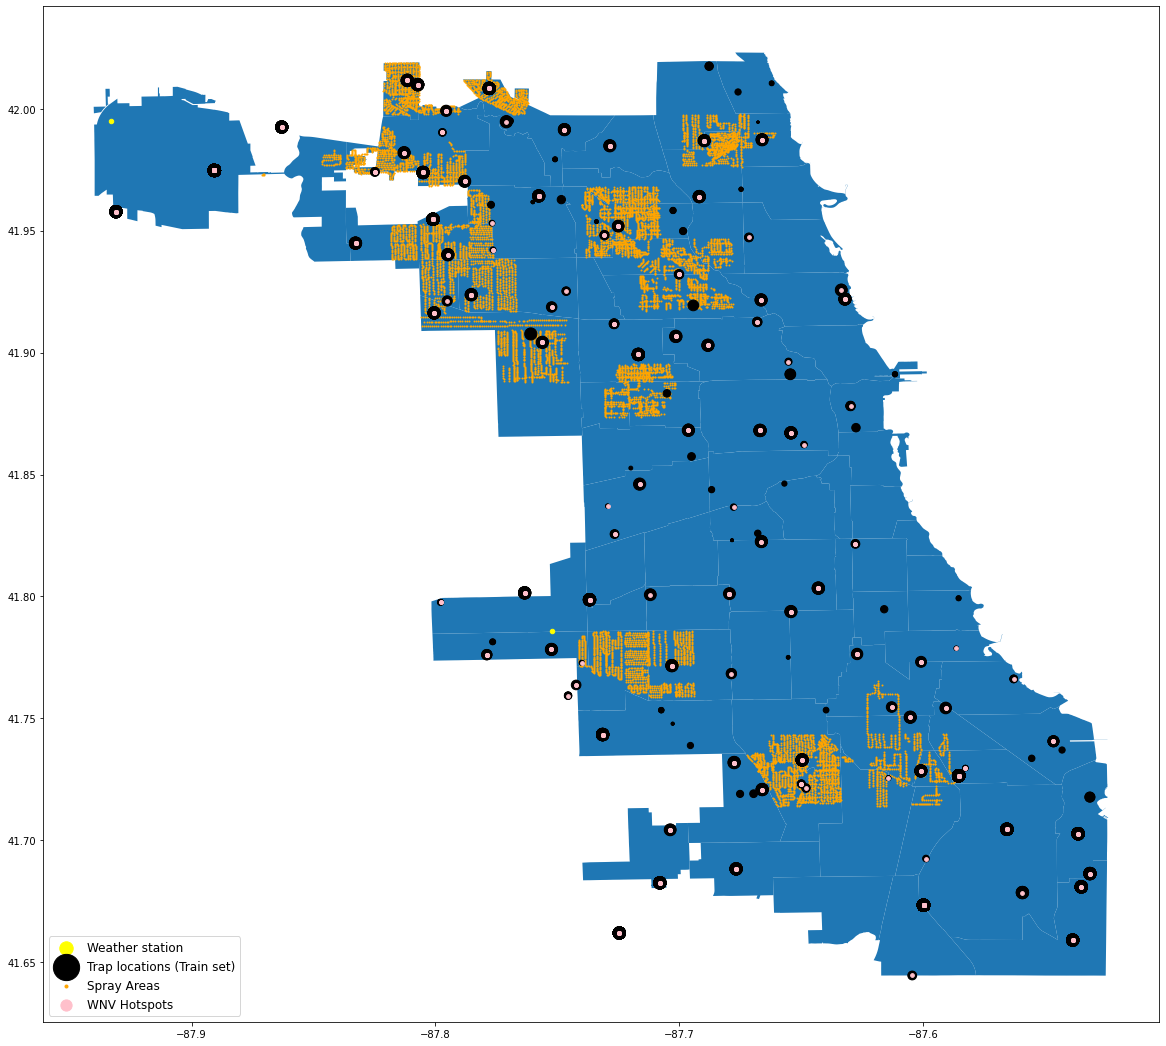

In [74]:
dict_df = {'Trap locations (Train set)':df_train, 
           'Spray Areas':df_spray, 
           'WNV Hotspots':df_wnvpresent
          }
plot_geodata(dict_df)

It is very hard to visualise the relationship between mosquitoes, the WNV hotspots and spray areas. In the spray analysis in our last notebook, we will break down the spraying effects by time to examine closer.

### EDA Weather data

Because there are only weather data from 2 weather stations,  we estimate the weather conditions at a particular location based on the proximity to the weather station.<br>

For example, if a trap is nearer to Station 1 than Station 2, we will use the weather data at Station 1 obtained at a particular date.

In [75]:
# set up a function to calculate the distance between two points
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371  
    
    # calculate the result
    return(c * r)

# set up a function to find out which weather station a trap is closer to
# the function to be used in dataframe.apply()
def near_station(row):
    lat = row['Latitude']
    lon = row['Longitude']
    station1_lat = 41.995
    station1_lon = -87.933
    station2_lat = 41.786
    station2_lon = -87.752
    
    if distance(lat, station1_lat, lon, station1_lon) < distance(lat, station2_lat, lon, station2_lon):
        return 1
    else:
        return 2

In [76]:
df_train['Station'] = df_train.apply(near_station, axis=1)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  geometry                10506 non-null  geomet

In [77]:
# merging the weather information to the train dataset
df_train_weather = pd.merge(df_train, df_weather, how='left', on=('Date','Station'))
df_train_weather.shape

(10506, 40)

In [78]:
df_train_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  geometry                10506 non-null  geomet

In [79]:
df_train_weather.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,geometry,year,month,week,day,year_month,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Day_length
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0,POINT (-87.80099 41.95469),2007,5,22,29,2007-05,1,88,60,74.00,10,58,65,0,9,421,1917,BR HZ,0,M,0.0,0.00,29.39,30.11,5.80,18,6.5,14.93
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0,POINT (-87.80099 41.95469),2007,5,22,29,2007-05,1,88,60,74.00,10,58,65,0,9,421,1917,BR HZ,0,M,0.0,0.00,29.39,30.11,5.80,18,6.5,14.93
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.99,-87.77,9,1,0,POINT (-87.76928 41.99499),2007,5,22,29,2007-05,1,88,60,74.00,10,58,65,0,9,421,1917,BR HZ,0,M,0.0,0.00,29.39,30.11,5.80,18,6.5,14.93
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,1,0,POINT (-87.82481 41.97409),2007,5,22,29,2007-05,1,88,60,74.00,10,58,65,0,9,421,1917,BR HZ,0,M,0.0,0.00,29.39,30.11,5.80,18,6.5,14.93
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,4,0,POINT (-87.82481 41.97409),2007,5,22,29,2007-05,1,88,60,74.00,10,58,65,0,9,421,1917,BR HZ,0,M,0.0,0.00,29.39,30.11,5.80,18,6.5,14.93


In [80]:
# select only numeric columns from df_weather
print(df_weather.select_dtypes(include=np.number).columns.tolist())

['Station', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'Sunrise', 'Sunset', 'PrecipTotal', 'ResultSpeed', 'ResultDir', 'Day_length']


In [81]:
# create a df with numeric weather features, as well as number of mosquitos and WnvPresent
weather = df_train_weather[['Date', 'WnvPresent', 'NumMosquitos', 'year', 'month', 'week',
                            'year_month', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'Sunrise', 'Sunset',
                            'PrecipTotal', 'ResultSpeed', 'ResultDir', 'Day_length']]

In [82]:
# groupby year_month so that it is easier to analyse trend
weather_yrmonth = weather.groupby('year_month').mean()
weather_yrmonth

,WnvPresent,NumMosquitos,year,month,week,Tmax,Tmin,Tavg,DewPoint,Sunrise,Sunset,PrecipTotal,ResultSpeed,ResultDir,Day_length
year_month,,,,,,,,,,,,,,,
2007-05,0.00,1.60,"2,007.00",5.00,22.00,88.00,63.60,76.16,58.72,421.00,"1,917.00",0.00,5.80,16.56,14.93
2007-06,0.00,2.43,"2,007.00",6.00,24.98,76.43,59.94,68.32,58.12,417.92,"1,928.27",0.14,6.62,10.36,15.17
2007-07,0.01,12.52,"2,007.00",7.00,28.78,81.13,65.45,73.56,59.51,431.06,"1,923.91",0.28,7.38,24.08,14.88
2007-08,0.10,19.52,"2,007.00",8.00,32.54,87.00,70.12,78.78,66.72,471.25,"1,876.34",0.22,4.31,15.72,14.01
2007-09,0.04,12.02,"2,007.00",9.00,37.47,84.33,64.66,74.67,57.78,531.17,"1,782.13",0.01,6.75,18.11,12.53
2007-10,0.01,8.09,"2,007.00",10.00,40.12,82.02,54.07,68.55,54.52,552.62,"1,727.89",0.00,5.36,18.36,11.59
2009-05,0.00,3.22,"2,009.00",5.00,22.00,63.42,54.71,59.42,51.00,421.00,"1,916.00",0.00,6.80,29.29,14.92
2009-06,0.00,12.79,"2,009.00",6.00,24.56,78.10,57.69,68.16,54.40,417.24,"1,926.95",0.31,6.62,11.61,15.16
2009-07,0.01,11.70,"2,009.00",7.00,29.44,79.97,61.78,71.04,55.76,432.91,"1,922.59",0.04,7.24,24.39,14.83


In [92]:
weather_yrmonth.columns

Index(['WnvPresent', 'NumMosquitos', 'year', 'month', 'week', 'Tmax', 'Tmin',
       'Tavg', 'DewPoint', 'Sunrise', 'Sunset', 'PrecipTotal', 'ResultSpeed',
       'ResultDir', 'Day_length'],
      dtype='object')

In [94]:
# make a smaller subset of weather_yrmonth to do correlation table
df_weather_corr = weather_yrmonth[['WnvPresent', 'NumMosquitos', 'Tmax', 'Tmin',
                                   'Tavg', 'DewPoint', 'Sunrise', 'Sunset', 'PrecipTotal',
                                   'ResultSpeed', 'ResultDir', 'Day_length']]

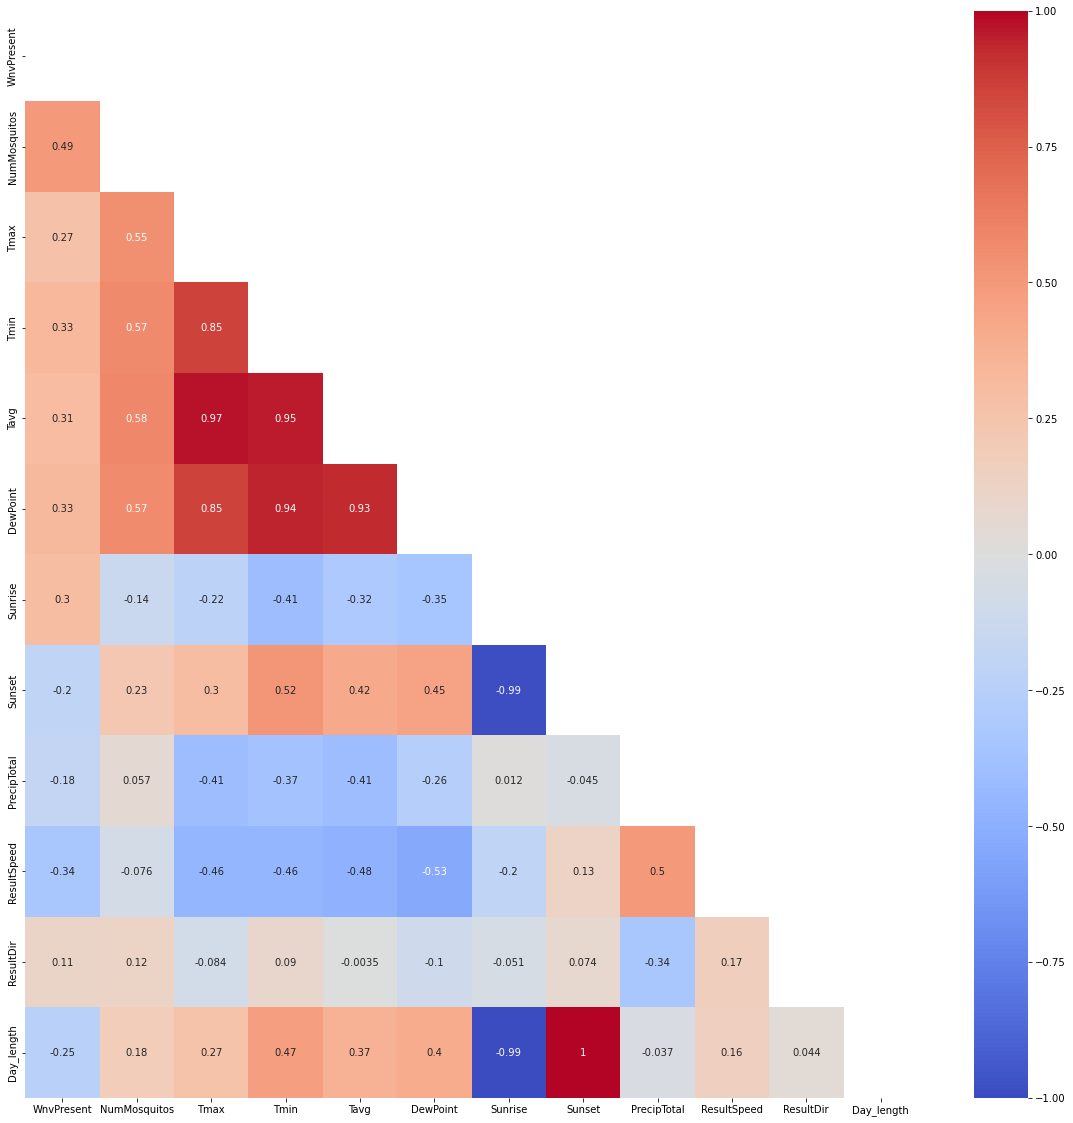

In [95]:
mask = np.zeros_like(df_weather_corr.corr())
mask[np.triu_indices_from(mask)]=True

plt.figure(figsize=(20,20))
sns.heatmap(df_weather_corr.corr(), annot=True,\
            mask=mask, vmin=-1, vmax=1, cmap='coolwarm');

**Looking at the first 2 columns of the correlation heatmap, temperature and dewpoint seems to have a high and positive correlation predicting the presence of the WNV, while the resultant wind speed and day length are negatively correlated.**

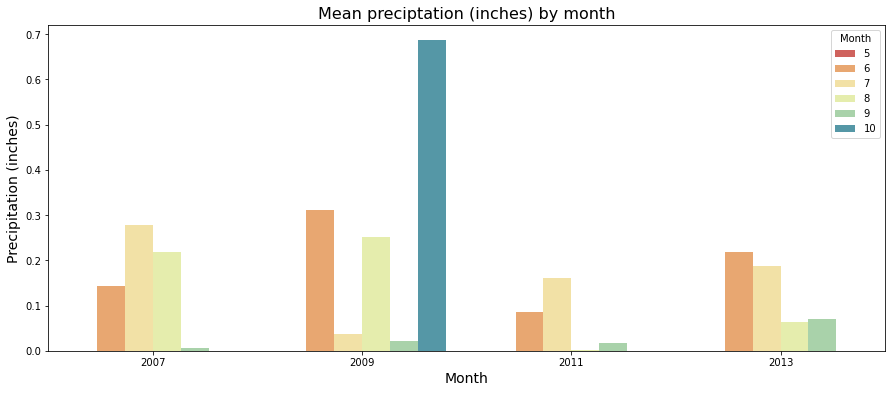

In [84]:
# create plot of mean precipitation by month
fig, ax = plt.subplots(nrows=1, figsize=(15,6))

# Mean precipitation
sns.barplot(x='year', y='PrecipTotal', data=weather,
            hue='month', ci=None, palette='Spectral')
ax.set_title('Mean preciptation (inches) by month', fontsize=16)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Precipitation (inches)', fontsize=14)
ax.legend(title='Month', loc="upper right")
plt.show()

In [108]:
# for each month-year, how many days of data was t
weather.groupby('year_month')['Date'].nunique().sort_values()

year_month
2007-05     1
2009-05     1
2009-10     1
2007-10     2
2007-06     3
2013-07     4
2011-08     4
2011-07     4
2011-06     4
2009-09     4
2009-08     4
2013-09     4
2013-06     5
2013-08     5
2011-09     6
2007-07     6
2009-07     7
2007-09     8
2009-06     9
2007-08    13
Name: Date, dtype: int64

In [85]:
weather.query("year_month=='2009-10'").head()

,Date,WnvPresent,NumMosquitos,year,month,week,year_month,Tmax,Tmin,Tavg,DewPoint,Sunrise,Sunset,PrecipTotal,ResultSpeed,ResultDir,Day_length
5995,2009-10-01,0,2,2009,10,40,2009-10,59,44,52.00,46,548,1734,0.59,8.80,13,11.77
5996,2009-10-01,0,11,2009,10,40,2009-10,59,44,52.00,46,548,1734,0.59,8.80,13,11.77
5997,2009-10-01,0,1,2009,10,40,2009-10,59,44,52.00,46,548,1734,0.59,8.80,13,11.77
5998,2009-10-01,0,1,2009,10,40,2009-10,59,44,52.00,46,548,1734,0.59,8.80,13,11.77
5999,2009-10-01,0,2,2009,10,40,2009-10,59,41,50.00,46,548,1734,0.89,9.10,13,11.77


**The amount of precipitation seems to be fluctuating and does not follow a specific seasonal trend. At first glance, it seemed that June or July are the wettest months, but across years the rainfall can vary greatly month to month. In 2009 Oct, the precipitation looks to be greater than usual, but as explored above, the entry is only based on one single day. Perhaps more data point is needed to do a more accurate weather analysis.**

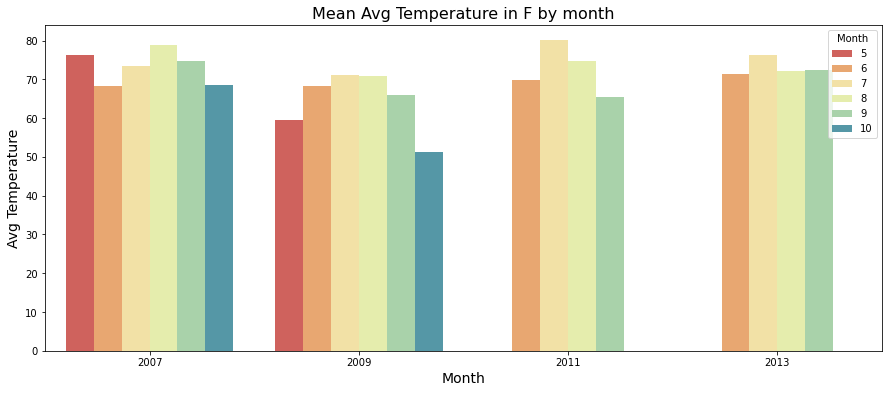

In [86]:
# create plot of Avg temperature by month
fig, ax = plt.subplots(nrows=1, figsize=(15,6))

# Avg monthly temperature
sns.barplot(data=weather, x='year', y='Tavg', 
            hue='month', ci=None, palette='Spectral')
ax.legend(fontsize = 14)
ax.set_title('Mean Avg Temperature in F by month', fontsize=16)
ax.set_ylabel("Avg Temperature",fontsize=14)
ax.set_xlabel("Month", fontsize=14)
plt.legend(title='Month', loc="upper right")
plt.show()

**The hottest months are occuring in July and August and then temperature gradually drops off. There is clear seasonlity seen in the visualisation.**

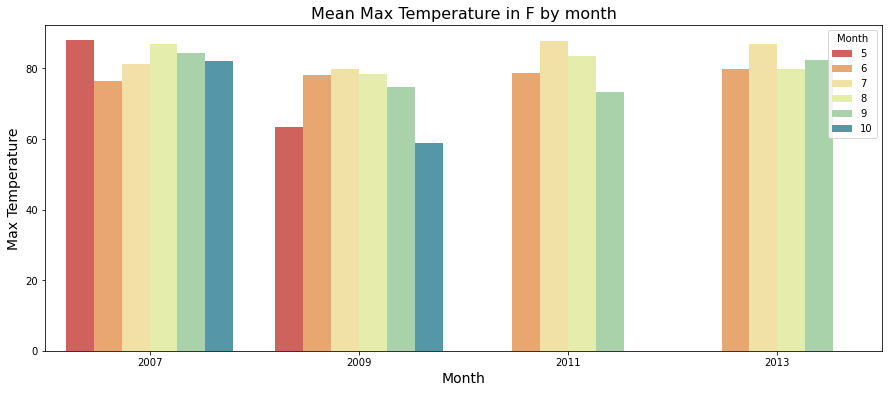

In [87]:
# create plot of Avg temperature by month
fig, ax = plt.subplots(nrows=1, figsize=(15,6))

# Max monthly temperature
sns.barplot(data=weather, x='year', y='Tmax', 
            hue='month', ci=None, palette='Spectral')
ax.legend(fontsize = 14)
ax.set_title('Mean Max Temperature in F by month', fontsize=16)
ax.set_ylabel("Max Temperature",fontsize=14)
ax.set_xlabel("Month", fontsize=14)
plt.legend(title='Month', loc="upper right")
plt.show()

**Same conclusion as per above, the hottest months are occuring in July and August.**

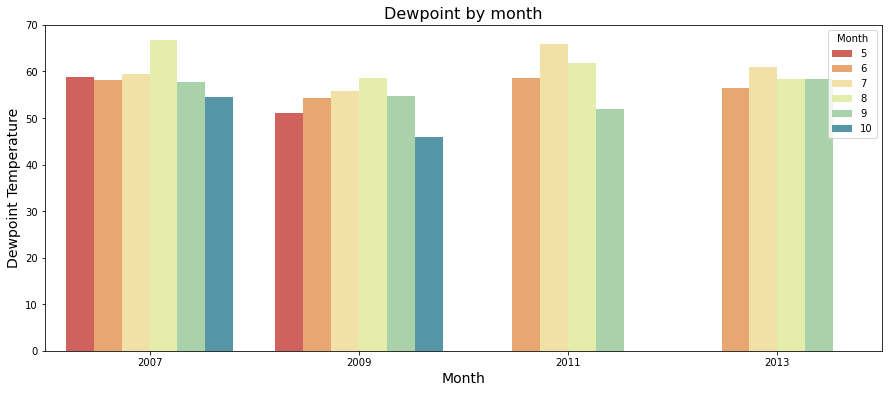

In [98]:
# create plot of Dewpoint by month
fig, ax = plt.subplots(nrows=1, figsize=(15,6))

# Max monthly temperature
sns.barplot(data=weather, x='year', y='DewPoint', 
            hue='month', ci=None, palette='Spectral')
ax.legend(fontsize = 14)
ax.set_title('Dewpoint by month', fontsize=16)
ax.set_ylabel("Dewpoint Temperature",fontsize=14)
ax.set_xlabel("Month", fontsize=14)
plt.legend(title='Month', loc="upper right")
plt.show()

**Dewpoint is highly correlated to temperature, so the seasonal trend is quite similar to above.**

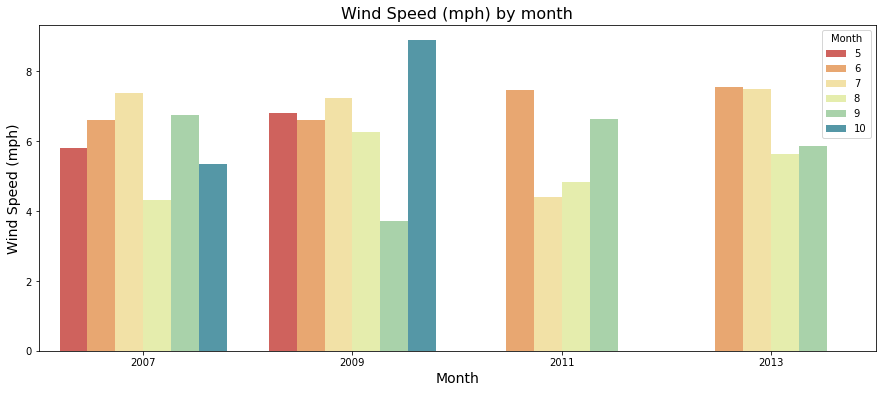

In [88]:
# create plot of Resultant Wind Speed by month
fig, ax = plt.subplots(nrows=1, figsize=(15,6))

# Resultant wind speed
sns.barplot(data=weather, x='year', y='ResultSpeed', 
            hue='month', ci=None, palette='Spectral')
ax.legend(fontsize = 14)
ax.set_title('Wind Speed (mph) by month', fontsize=16)
ax.set_ylabel("Wind Speed (mph)",fontsize=14)
ax.set_xlabel("Month", fontsize=14)
plt.legend(title='Month', loc="upper right")
plt.show()

**Seems that wind speed peaks, drops off and then increases again. The peak is sometime in June or July before tapering.**

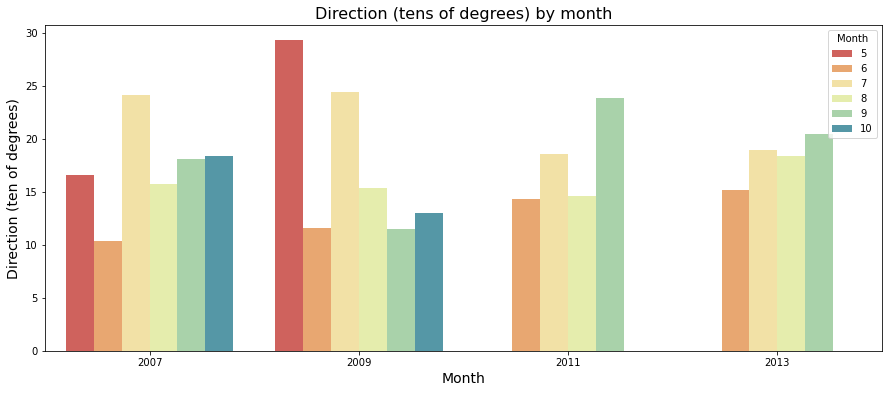

In [89]:
# create plot of Resultant Wind Direction by month
fig, ax = plt.subplots(nrows=1, figsize=(15,6))

# Resultant wind direction
sns.barplot(data=weather, x='year', y='ResultDir', 
            hue='month', ci=None, palette='Spectral')
ax.legend(fontsize = 14)
ax.set_title('Direction (tens of degrees) by month', fontsize=16)
ax.set_ylabel("Direction (ten of degrees)",fontsize=14)
ax.set_xlabel("Month", fontsize=14)
plt.legend(title='Month', loc="upper right")
plt.show()

**Unsure of how to use wind direction in our analysis. For now, no conclusion yet.**

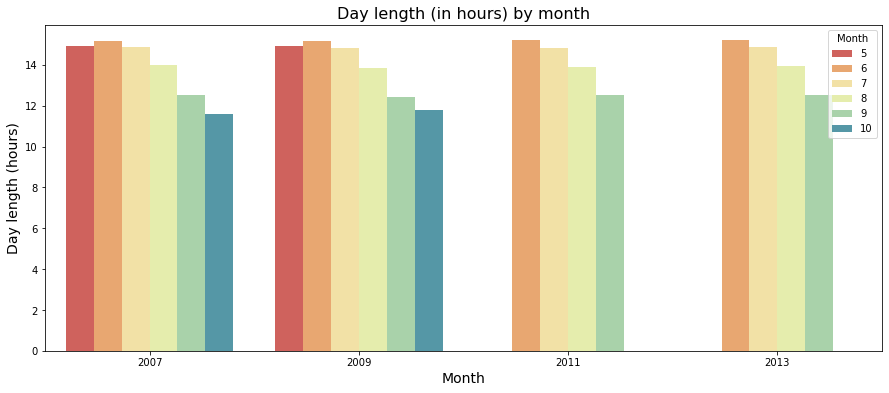

In [90]:
# create plot of Day length by month
fig, ax = plt.subplots(nrows=1, figsize=(15,6))

# Resultant wind direction
sns.barplot(data=weather, x='year', y='Day_length', 
            hue='month', ci=None, palette='Spectral')
ax.legend(fontsize = 14)
ax.set_title('Day length (in hours) by month', fontsize=16)
ax.set_ylabel("Day length (hours)",fontsize=14)
ax.set_xlabel("Month", fontsize=14)
plt.legend(title='Month', loc="upper right")
plt.show()

**The seasonality of day length is quite clear. The day is longest in the summer months from June and starts to decline after.**

## Pickle
*Back to [Contents](#Contents:)*

In [91]:
# save neccessary object to pickle_dict, 
# which will be pickled in other notebook for feature engineering and modeling

pickle_dict1 = dict()
pickle_dict1['df_train']=df_train
pickle_dict1['df_test']=df_test
pickle_dict1['df_spray']=df_spray
pickle_dict1['df_weather_1']=df_weather_1
pickle_dict1['df_weather_2']=df_weather_2
pickle.dump(pickle_dict1, open('./assets/data1.pkl', 'wb'))